## Domains of enrichment of H3K4Me2 and H3K27Me3

We predicted domains of enrichment (DOE) using RSEG. Here we plot to how much of a chromosome is part of a DOE of a histone modification, what is the size distribution of DOEs per chromosome. Moreover, we plot whether DOEs overlap with genes or repeats and how this affects a gene's _in vitro_ expression. 

To determine whether or to what extend release of H3K27Me3 occurs during infection, we study whether genes that are in a DOE are upregulated _in planta_ versus _in vitro_.


In [13]:
'''We start with making a few dictionaries mapping scaffolds to chromosomes, to their length, etc. etc'''

###### Chromosomal categories: category -> chromosomes/chromosomal regions  
chr_categories = ['core', 'fast-core', 'lineage-specific', 'pathogenicity']
cat2chrs = {}

cat2chrs['core']             = ['chr01','chr02','chr04','chr05','chr07','chr08','chr09','chr10']
cat2chrs['fast-core']        = ['chr11','chr12','chr13']
cat2chrs['lineage-specific'] = ['chr01_LS', 'chr02_LS', 'chr03A', 'chr06A','chr15']
cat2chrs['pathogenicity']    = ['chr14', 'chr03P', 'chr06P']

chrs = []
for cat in chr_categories:
    chrs += cat2chrs[cat]

###### Chromosome -> scaffold
# Scaffolds per chromosome or chromosomal region, in case of e.g. chr01_LS or chr03P 
chr2scaffolds = {}
chr2scaffolds['chr01']    = [14,1]
chr2scaffolds['chr01_LS'] = [27]
chr2scaffolds['chr02']    = [6,10]
chr2scaffolds['chr02_LS'] = [31]
chr2scaffolds['chr03A']   = [32, 7, 25]
chr2scaffolds['chr03P']   = [47, 18]
chr2scaffolds['chr04']    = [8,4]
chr2scaffolds['chr05']    = [26, 2]
chr2scaffolds['chr06A']   = [9, 33]
chr2scaffolds['chr06P']   = [21, 53, 41, 42]
chr2scaffolds['chr07']    = [5, 13]
chr2scaffolds['chr08']    = [3, 29]
chr2scaffolds['chr09']    = [11, 17]
chr2scaffolds['chr10']    = [20, 15, 45]
chr2scaffolds['chr11']    = [35, 12]
chr2scaffolds['chr12']    = [19, 23]
chr2scaffolds['chr13']    = [16, 39]
chr2scaffolds['chr14']    = [22, 43, 51, 36]
chr2scaffolds['chr15']    = [37, 38, 24, 28]

# Also the other way around
###### Scaffold -> chromosome
scaffold2chromosome = {}
for chrom in chr2scaffolds.keys():
    for s in chr2scaffolds[chrom]:
        scaffold2chromosome['Supercontig_2.'+str(s)] = chrom

###### Scaffold -> length
genomeFilename = 'data/fusarium_oxysporum_f._sp._lycopersici_4287_2_supercontigs.contig2size.tab'
contig2size = {}
for line in open(genomeFilename).readlines():
    contig, size = line.strip().split('\t')
    contig2size[contig] = float(size)
    
# Chromosome -> size
chr2size = {}
for chrom in chr2scaffolds.keys():
    chrsize = 0
    for s in chr2scaffolds[chrom]:
        scaffold2chromosome['Supercontig_2.'+str(s)] = chrom
        chrsize += contig2size['Supercontig_2.'+str(s)] 
    chr2size[chrom] = chrsize

# Add unpositioned scaffolds, make this a separate 'chromosome'
chr2scaffolds ['US'] = []
for scaffold in contig2size:
    if scaffold not in scaffold2chromosome:
        scaffold2chromosome[scaffold] = 'US'
        chr2scaffolds['US'].append(int(scaffold.split('Supercontig_2.')[-1]))
        
###### Genes per scaffold, location per gene
scaffold2genes   = {}
genes2strand2pos = {}
all_genes = set([])
for line in open('data/fusarium_oxysporum_f._sp._lycopersici_4287_2_transcripts.gtf').readlines():
    data = line.split('\t')
    scaffold = data[0]
    gene = data[-1].split('gene_id "')[-1].split('"')[0]
    
    # add to genes per scaffold
    if scaffold not in scaffold2genes:
        scaffold2genes[scaffold] = set([gene])
    else: scaffold2genes[scaffold].add(gene)
    all_genes.add(gene)
    
print(len(all_genes))

20925


### 1. How much of a chromosome is part of a DOE? How big are DOEs?

We want to know whether the differences between the two histone modifications:
* Are the DOEs typically small or large (specific versus aspecific regulation?)? 
* Are they clustered on the genome? Are they far apart?  
* How much of chromosome is covered by DOEs?


H3K4me2_1358
core 0.757039149705
fast-core 0.107532156783
lineage-specific 0.0599701562413
pathogenicity 0.124717003694


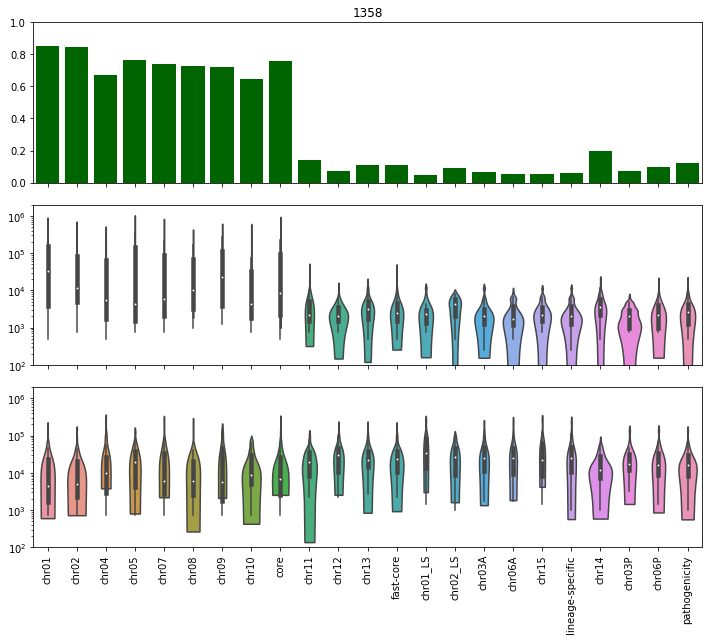

H3K4me2_806
core 0.498329539625
fast-core 0.0279156327543
lineage-specific 0.0272039847723
pathogenicity 0.0267699883078


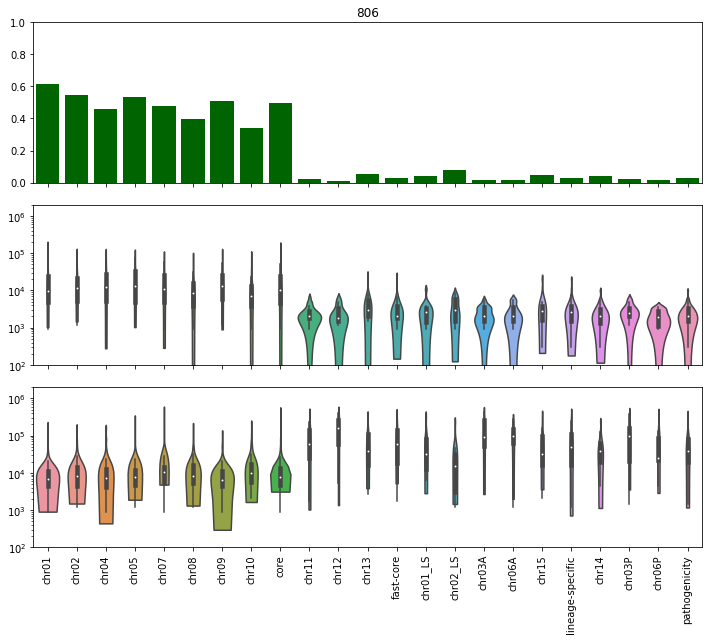

H3K27me3_1360
core 0.287519825076
fast-core 0.971191826607
lineage-specific 0.968237558638
pathogenicity 0.911396928259


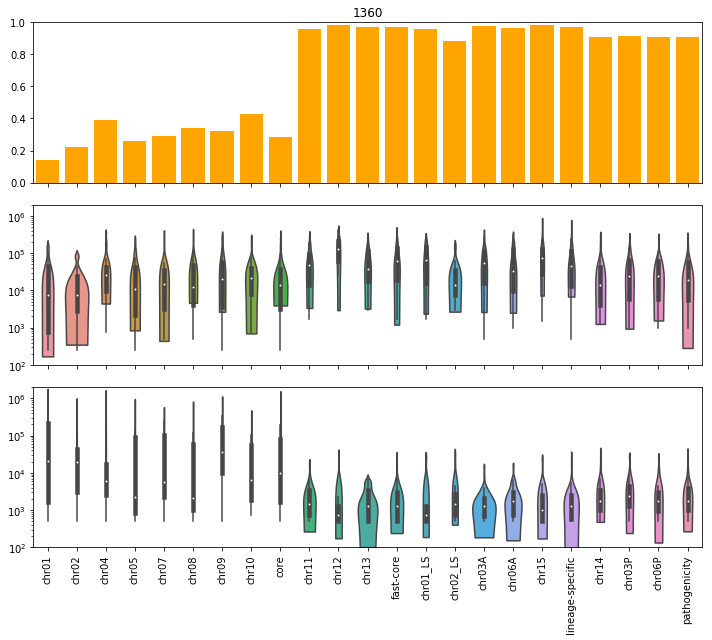

H3K27me3_808
core 0.266294953322
fast-core 0.933212956398
lineage-specific 0.724503262304
pathogenicity 0.468316491131


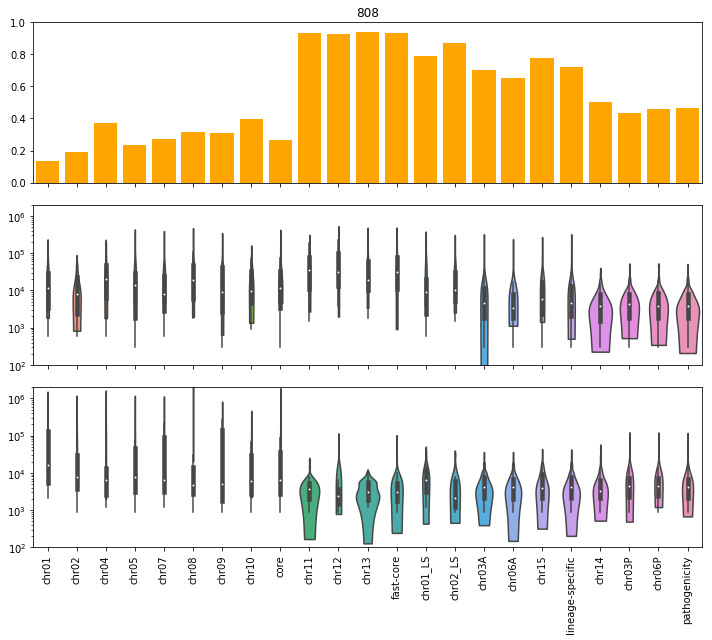

In [14]:
import glob, os
import seaborn as sns
from matplotlib import pyplot as plt 
import numpy as np
%matplotlib inline

plt.rcParams['figure.figsize'] = (10,9)

##### ChIPseq data
rseg_output_dir = 'data/ChIP-seq/'
postfix         = '.DOE.bed'

mark2expids = {}
hmarks  = ['H3K4me2', 'H3K27me3']
mark2expids['H3K4me2']  = ['1358', '806']
mark2expids['H3K27me3'] = ['1360', '808']
expid2color = {}
expid2color['1358']  = 'darkgreen'
expid2color['806'] = 'darkgreen'
expid2color['1360']  = 'orange'
expid2color['808'] = 'orange'

# get size distribution of DOEs per chromosome, and per chromosome category
# get distribution of gaps between DOEs to see whether they cluster on the genome

# Unfortunately, RSEG works with bins and these bins may actually exceed contig boundaries (stupid bug...)
# To at least not count these we have to check whether DOE boundaries do not exceed RSEG boundaries.
scaffold2size = {}
for line in open('data/fusarium_oxysporum_f._sp._lycopersici_4287_2_supercontigs.contig2size.tab').readlines():
    scaffold, size = line.strip().split()
    scaffold2size[scaffold] = int(size)
    
for hmark in hmarks:    
    for expid in mark2expids[hmark]:
        chr2sizes = {}
        chr2gaps  = {}
        for chr in chrs:
            chr2sizes[chr] = []
            chr2gaps[chr] = []
        chr2sizes['US']  = []
        chr2gaps['US'] = [] 
        
        rseg_bed = rseg_output_dir+hmark+'_'+expid+postfix
        bedfile  = open(rseg_bed)
        
        # first line
        line = bedfile.readline()
        data = line.strip().split('\t')
        scaffold = data[0]
        start,end = map(int, data[1:3])
        # avoid 'overshooting' scaffold boundaries because of binning in RSEG
        end = min(end,scaffold2size[scaffold])
        
        current_scaffold = scaffold
        CHR = 'US'
        if scaffold in scaffold2chromosome: 
            CHR = scaffold2chromosome[scaffold]
                
        domain_size = end-start
        chr2sizes[CHR].append(domain_size)
    
        # calculate gap between this DOE and the next
        line = bedfile.readline()
        prev_end = end
        while len(line) > 1:
            data = line.strip().split('\t')
            scaffold = data[0]

            start,end = map(int, data[1:3])
            # avoid 'overshooting' scaffold boundaries because of binning in RSEG
            end = min(end,scaffold2size[scaffold])
            
            CHR = 'US'
            if scaffold in scaffold2chromosome: 
                CHR = scaffold2chromosome[scaffold]

            # gap between regions:
            if scaffold == current_scaffold:
                dist_domains = start-prev_end
                chr2gaps[CHR].append(dist_domains)
            else:
                current_scaffold = scaffold

            # size of next domain
            domain_size = end-start
            chr2sizes[CHR].append(domain_size)

            prev_end = end
            line = bedfile.readline()

        print(rseg_bed.split('/')[-1].split('.')[0])

        # per category, calculate how much of the chromosome is part of a DOE, plot this coverage in a histogram
        # plot distribution of sizes and gaps between DOEs in a violin plot
        coverageInPlot = []
        sizesInPlot    = []
        gapsInPlot     = []
        for cat in chr_categories:
            cat_totalsize = 0
            cat_coverage  = 0
            cat_sizes     = []
            cat_gaps      = []

            for chr in cat2chrs[cat]:
                sizes_regions = chr2sizes[chr]
                sizesInPlot.append(sizes_regions)
                cat_sizes += sizes_regions

                gaps_regions  = chr2gaps[chr]
                gapsInPlot.append(gaps_regions)
                cat_gaps += gaps_regions

                coverage = np.sum(sizes_regions)
                coverageInPlot.append(coverage/chr2size[chr])
                cat_totalsize += chr2size[chr]
                cat_coverage += coverage

            coverageInPlot.append(cat_coverage/float(cat_totalsize))
            print(cat, cat_coverage/float(cat_totalsize))
            sizesInPlot.append(cat_sizes)
            gapsInPlot.append(cat_gaps)

        plt.figure()
        f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
        ax1.set_facecolor('w')
        ax2.set_facecolor('w')
        ax3.set_facecolor('w')
    
        xlabels = []
        for cat in chr_categories:
            for chr in cat2chrs[cat]:
                xlabels.append(chr)
            xlabels.append(cat)
            
        ax1.set_title(expid.split('_')[0]) 
        
        ax1.bar(range(len(coverageInPlot)), coverageInPlot, color = expid2color[expid])
        ax1.set_ylim(0, 1)
        sns.violinplot(data = sizesInPlot, ax = ax2)
        #sns.violinplot(data = sizesInPlot, inner="stick", ax = ax2)
        ax2.set(yscale="log")
        ax2.set_ylim(100, 2000000)
        sns.violinplot(data = gapsInPlot, ax = ax3)
        #sns.violinplot(data = gapsInPlot, inner="stick", ax = ax3)
        ax3.set(yscale="log")
        ax3.set_ylim(100, 2000000)
        ax3.set_xticks(range(len(coverageInPlot)))
        ax3.set_xticklabels(xlabels,rotation='vertical')
       
        plt.tight_layout()
        plt.savefig(rseg_output_dir+expid+'_bar_violin_DOE.eps')
        plt.show()
        

    



### 2. Overlap of DOEs with genes (intron, exons), promoterregions, repeats

In [15]:
plt.rcParams['figure.figsize'] = (10,15)

def get_chr2Nelements(bedfilename, sc2chr):
    #count   
    chr2Nelements = {}
    for line in open(bedfilename).readlines():
        scaffold = line.split('\t')[0]
        if scaffold in sc2chr.keys():
            chr = sc2chr[scaffold]
            if chr in chr2Nelements.keys():
                chr2Nelements[chr] += 1
            else:
                chr2Nelements[chr] = 1
            
    return chr2Nelements



gene_bed     = 'GENES/Fol4287__genes.nr.bed' 
intron_bed   = 'GENES/Fol4287__introns.nr.bed'
exon_bed     = 'GENES/Fol4287__exons.nr.bed'
promoter_bed = 'GENES/Fol4287__promoters.nr.bed'

lc_bed       = 'REPEATS/Fol4287_RepeatMasker.Simple_repeats__Low_complexity.bed'
repeat_bed   = 'REPEATS/Fol4287_Repeats.bed'

OUTDIR = rseg_output_dir

compare_beds = [gene_bed, intron_bed, exon_bed, promoter_bed, lc_bed, repeat_bed]
colors       = ['#6B8E23', '#FFD700', '#1E90FF', '#E9967A', '#7F7F7F', '#800080']
bed2chr2Nelements = {}
for compare_bed in compare_beds:
    # get number of elements (e.g. genes, introns, repeats, etc. per chromosome)
    bed2chr2Nelements[compare_bed] = get_chr2Nelements(compare_bed, scaffold2chromosome)
        
for hmark in hmarks:    
    for expid in mark2expids[hmark]:
        print(expid)
        rseg_bed = rseg_output_dir+expid+postfix
        
        # get the number of domains that overlap with an intron, exon, etc.
        bedfname2PercElementsWO = {}
        for compare_bed in compare_beds:
            # number of elements (e.g. genes, introns, repeats, etc. per chromosome)
            chr2Nelements = bed2chr2Nelements[compare_bed]
            
            # get elements that overlap for more than 90% with a DOE
            # use bedtools intersect,   overlap for more than 90%: -f 0.9
            outfilename = OUTDIR+compare_bed.split('/')[-1].split('.bed')[0]+'__'\
                            +rseg_bed.split('/')[-1].split('.mapped2')[0]+'.bed'  
                
            cmnd = 'bedtools intersect -a '+compare_bed+' -b '+rseg_bed+\
                   ' -wa -f 0.9 | gsort -k1,1 -V -k2,2n | uniq > '+outfilename
            
            if not os.system(cmnd) == 0:
                print('FAILED:', cmnd)
            
            chr2NelementsWithOverlap = get_chr2Nelements(outfilename, scaffold2chromosome)
            
            # plot number of elements per chromosome, and fraction of elements that overlap with DOE per chromosome
            PercElementsWO = []
            for cat in chr_categories:
                cat_Nelements   = 0
                cat_NelementsWO = 0
                
                for chr in cat2chrs[cat]:
                    PercElementsWO.append((chr2NelementsWithOverlap[chr]*100)/float(chr2Nelements[chr]))
                    cat_Nelements += chr2Nelements[chr]
                    cat_NelementsWO += chr2NelementsWithOverlap[chr]
                    
                PercElementsWO.append((cat_NelementsWO*100)/float(cat_Nelements))
                
            bedfname2PercElementsWO[compare_bed] = PercElementsWO
            
        plt.figure()
        
        #chromosome names and categories on x-axis
        xlabels = []
        for cat in chr_categories:
            for chr in cat2chrs[cat]:
                xlabels.append(chr)
            xlabels.append(cat)
        
        #plot Perc elements with overlap as a barchart
        f, axes = plt.subplots(len(compare_beds), 1, sharex=True)
        axes[0].set_title(expid.split('_')[0])
        
       
        for ax in axes:   
            ax.set_facecolor('w')
            ax.set_ylim(0,100)
            
        for idx, compare_bed in enumerate(compare_beds):
            print(compare_bed.split('/')[-1])
            print('Core:', min(bedfname2PercElementsWO[compare_bed][:8]),\
                        max(bedfname2PercElementsWO[compare_bed][:8]),\
                        bedfname2PercElementsWO[compare_bed][8])
            print('Fast-core:', min(bedfname2PercElementsWO[compare_bed][9:12]),\
                        max(bedfname2PercElementsWO[compare_bed][9:12]),\
                        bedfname2PercElementsWO[compare_bed][12])
            print('Lin-spec:', min(bedfname2PercElementsWO[compare_bed][13:19]),\
                        max(bedfname2PercElementsWO[compare_bed][13:19]),\
                        bedfname2PercElementsWO[compare_bed][19])
            print('Path:', min(bedfname2PercElementsWO[compare_bed][19:]),\
                        max(bedfname2PercElementsWO[compare_bed][19:]),\
                        bedfname2PercElementsWO[compare_bed][-1])
            print('')     
            axes[idx].bar(range(len(xlabels)), bedfname2PercElementsWO[compare_bed], color = colors[idx])
        print('\n')
        axes[-1].set_xticks(range(len(xlabels)))
        axes[-1].set_xticklabels(xlabels,rotation='vertical')
    
        
        plt.tight_layout()
        plt.savefig(rseg_output_dir+expid+'_overlap_DOE.eps')
        plt.show()





           

1358


KeyError: 'chr01'

### 3. Differences in expression levels for genes that lie in an DOE
#### 3a. Do genes that lie in a DOE of H3K4Me2 (activator) have a higher _in vitro_ expression level?
#### 3b. Do genes that lie in a DOE of H3K27Me3 (repressor) have a lower _in vitro_ expression level?



H3K4Me2 1358_lane7-index13 251.10004755 38.43961014 84.8265858063 0.0
Ttest_indResult(statistic=4.3398385640938635, pvalue=1.4337119779983387e-05)
MannwhitneyuResult(statistic=18876183.0, pvalue=0.0)


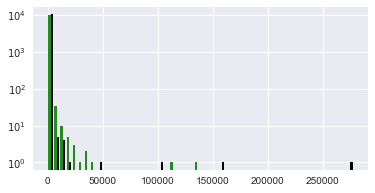

H3K4Me2 HTS806_lane5-index0004 272.702479811 75.67894319 117.997843011 0.296093592
Ttest_indResult(statistic=5.0803888657278273, pvalue=3.8017725547463359e-07)
MannwhitneyuResult(statistic=14507755.0, pvalue=0.0)


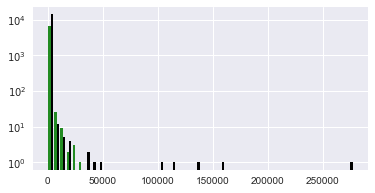

H3K27Me3 1360_lane7-index15 96.6763569175 0.23658472 255.269574408 45.151934105
Ttest_indResult(statistic=-4.3538185822919866, pvalue=1.345016918805658e-05)
MannwhitneyuResult(statistic=19208343.5, pvalue=0.0)


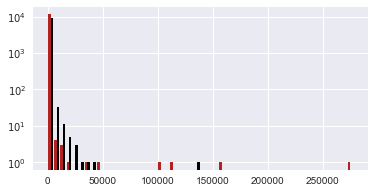

H3K27Me3 808_lane5-index0006 86.4213112268 0.258131724 234.633334371 24.550410065
Ttest_indResult(statistic=-3.9225239160570071, pvalue=8.7907230094563029e-05)
MannwhitneyuResult(statistic=26540626.5, pvalue=0.0)


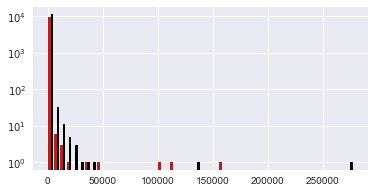

In [8]:
import scipy
# get genes that overlap with a DOE, per experiment
RPKM_in_vitro_fname = '../../three-speed_genome/values_per_gene/in_vitro_RPKM.tab'
gene2RPKM = {}
for line in open(RPKM_in_vitro_fname).readlines():
    data=line.strip().split('\t')
    gene2RPKM[data[0]] = float(data[1].replace(',', '.'))

for hmark in hmarks:    
    for expid in mark2expids[hmark]:
        rseg_bed = rseg_output_dir+expid+postfix
        
        bed_genesInDoe = OUTDIR+gene_bed.split('/')[-1].split('.bed')[0]+'__'\
                            +rseg_bed.split('/')[-1].split('.mapped2')[0]+'.bed' 
        
        genes_inDOE = set([])
        for line in open(bed_genesInDoe).readlines():
            genes_inDOE.add(line.strip().split('\t')[-1].split('T')[0])
            
        RPKM_DOE = []
        RPKM_notDOE = []
        for gene in gene2RPKM.keys():
            rpkm = gene2RPKM[gene]
            if gene in genes_inDOE:
                RPKM_DOE.append(rpkm)
            else: RPKM_notDOE.append(rpkm)
                    
        print hmark, expid, np.mean(RPKM_DOE), np.median(RPKM_DOE), np.mean(RPKM_notDOE), np.median(RPKM_notDOE)
        print scipy.stats.ttest_ind(RPKM_DOE, RPKM_notDOE, equal_var = False)
        print scipy.stats.mannwhitneyu(RPKM_DOE, RPKM_notDOE)
        
        
        plt.figure(figsize = (6,3), facecolor='white')
        plt.yscale('log')
        plt.hist([RPKM_DOE, RPKM_notDOE], bins = 50, color=[expid2color[expid],'black'])#, alpha=0.5)
        plt.show()
        

